# Cart Pole DQN

## Introduction

This sample code is test the capability of a Deep Q-learning Neural network. Q-Learning is off-policy reinforcement learning method. The network chosen was a linear neural network as the input dimension is 1d. Therefore, this network is but powerful when looking at the results. The main reason why this method works is from the training by creating a replay memory and storing experience here in a queue with each new state pushing out the oldest state. Using the replay memory, the model can take sample batches and learning from previous experiences. 

The model has two policies as this is off-policy. One is the policy is uses to learn to play the game and one is for the most optital play, Behaviour and target policy. The behaviour policy will up the target policy and eventually converge. The model chooses exploration and exploitation actions based off the epsilon greedy method which leads to better results as the model is deterministic. A simulation of the model can be seen at the bottom.

## Imports

In [14]:
import math
import random
import numpy as np
from collections import namedtuple, deque
import time

import gymnasium as gym

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [15]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Initial the game

No wrapper is used as the game observation spaces is simple

In [3]:
env = gym.make('CartPole-v1')

num_actions = env.action_space.n
input_shape = env.observation_space.shape

print("Number of actions = ", num_actions)
print("State shape = ", input_shape)

Number of actions =  2
State shape =  (4,)


## DQN Creation

In [4]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_outputs = num_outputs

        self.fc_layers = nn.Sequential(
            nn.Linear(input_shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, self.num_outputs)
        )
    
    def forward(self, x):
        return self.fc_layers(x)

In [5]:
# Create policy and target network.
policy_net = DQN(input_shape=input_shape, num_outputs=num_actions)
target_net = DQN(input_shape=input_shape, num_outputs=num_actions)

target_net.load_state_dict(policy_net.state_dict())

state = env.reset()[0]

with torch.no_grad():
    output = policy_net(torch.tensor(state).unsqueeze(0))

output

tensor([[-0.1135,  0.0680]])

In [17]:
policy_net.eval()

DQN(
  (fc_layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

## Replay memory

This uses the named tuple to retrieve information. Having everything group together makes it easier associate rewards and next states with the current state and the chosen action.

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def replay(self):
        
        if(self.__len__() < self.batch_size): return
        
        batch = Transition(*zip(*self.sample()))
        
        # terminated_mask = torch.tensor(tuple([s is not None for s in batch.next_state]), device=device, dtype=torch.bool)
        
        # Tensor with Boolean values of if the next state terminates the episode
        terminated_mask = []
        non_terminated_next_states = []
        
        # Append all Non terminated next states and also create a terminated mask for all states
        for s in batch.next_state:
            terminated = s is None
            if(not terminated): non_terminated_next_states.append(s)
            terminated_mask.append(not terminated)
        
        # Change to a tensor
        terminated_mask = torch.tensor(tuple(terminated_mask), device=device, dtype=torch.bool)
        non_terminated_next_states = torch.cat(non_terminated_next_states)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        # Flatten results to the length of the action_batch.
        # (All Q values are sorted by action.) 
        # Computes Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
        state_action_values = policy_net(state_batch).gather(1, action_batch)
        
        # Compute V(s_{t+1}) for all next states.
        # Expected target reward initialised to 0 for terminated states
        next_state_values = torch.zeros(self.batch_size, device=device)
        
        # Fill expected reward with non terminated next states using the target net
        with torch.no_grad():
            next_state_values[terminated_mask] = target_net(non_terminated_next_states).max(1).values
            
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * gamma) + reward_batch

        loss = loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        optimiser.zero_grad()
        loss.backward()
        
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        optimiser.step()
        
    def __len__(self):
        return len(self.memory)

# Intialise the hyperparameters

This is where the main adjustments are made. A huber loss was chosen as it punishes outliers less (exploration) even if it results in fails.

In [7]:
# Hyperparameters
alpha = 1e-4  # learning rate
gamma = 0.99 # Discount fator

# Optimiser and loss function
loss_fn = nn.HuberLoss()
optimiser = optim.AdamW(policy_net.parameters(), lr=alpha, amsgrad=True)

# Epsilon
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005

# Replay memory parameters
capacity = 10000
batch_size = 128
memory = ReplayMemory(capacity=capacity, batch_size=batch_size)

## Training

A set amount of games is played till termination or truncation. Termination is bad as this means that the poll dropped. As such the next state is 0 and the rewards are not give to the agent. Truncation is good as that means the game ended with the max score , 500. The agent will be awarded the full amount.

In [8]:
episodes = 500
verbose = True
steps = 0
epsilon_track = []
episode_reward_track = []

for episode in range(episodes):
    state = torch.tensor(env.reset()[0], dtype=torch.float32, device=device).unsqueeze(0)
    rewards = 0
    terminated, truncated = False, False
    found = False

    while not terminated and not truncated:
        
        # Epsilon
        epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-steps / EPS_DECAY)
        steps += 1
        
        # Explore
        if(random.uniform(0,1) <= epsilon):
            action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        
        # Exploit
        else: 
            with torch.no_grad():
                action = policy_net(state).max(1).indices.view(1, 1)

        next_state, reward, terminated, truncated, info = env.step(action.item())
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        
        rewards += reward
        reward = torch.tensor([reward], device=device)
        
        # -- Update Model --
        memory.push(state, action, next_state, reward)
        state = next_state
        memory.replay()
        
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        
        target_net.load_state_dict(target_net_state_dict)
    
    epsilon_track.append(epsilon)
    episode_reward_track.append(rewards)
    
    if(verbose): print(f"Episode: {episode + 1}, Total Reward: {rewards}")

Episode: 1, Total Reward: 10.0
Episode: 2, Total Reward: 24.0
Episode: 3, Total Reward: 11.0
Episode: 4, Total Reward: 15.0
Episode: 5, Total Reward: 40.0
Episode: 6, Total Reward: 12.0
Episode: 7, Total Reward: 37.0
Episode: 8, Total Reward: 17.0
Episode: 9, Total Reward: 14.0
Episode: 10, Total Reward: 14.0
Episode: 11, Total Reward: 26.0
Episode: 12, Total Reward: 13.0
Episode: 13, Total Reward: 12.0
Episode: 14, Total Reward: 14.0
Episode: 15, Total Reward: 9.0
Episode: 16, Total Reward: 15.0
Episode: 17, Total Reward: 54.0
Episode: 18, Total Reward: 12.0
Episode: 19, Total Reward: 34.0
Episode: 20, Total Reward: 14.0
Episode: 21, Total Reward: 15.0
Episode: 22, Total Reward: 10.0
Episode: 23, Total Reward: 20.0
Episode: 24, Total Reward: 15.0
Episode: 25, Total Reward: 16.0
Episode: 26, Total Reward: 11.0
Episode: 27, Total Reward: 9.0
Episode: 28, Total Reward: 13.0
Episode: 29, Total Reward: 8.0
Episode: 30, Total Reward: 8.0
Episode: 31, Total Reward: 11.0
Episode: 32, Total Re

## Plotting Epsilon vs Reward

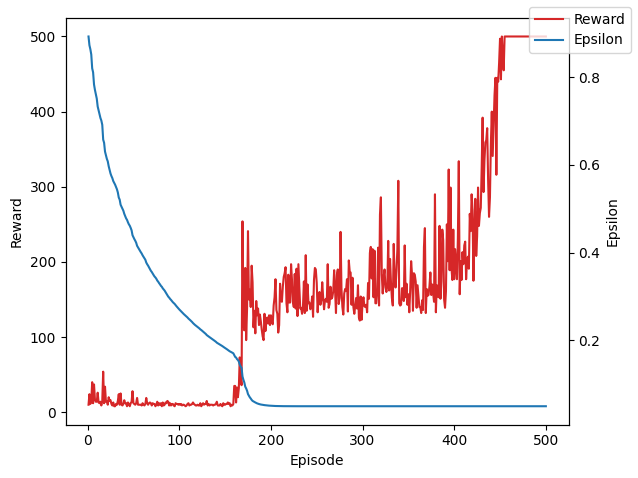

In [32]:
# Create some mock data
episode_i = list(range(1,episodes+1))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.plot(episode_i, episode_reward_track , color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Epsilon')  # we already handled the x-label with ax1
ax2.plot(episode_i, epsilon_track, color=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(["Reward", "Epsilon"])
plt.show()

# Evaluation of model

Plays 10 (default) games and average the scores. Could be used for grid search evaluations.

In [9]:
def evaluate(model, num_eps=10):

    # Evaluate the trained agent
    total_rewards = []
    for _ in range(num_eps):
        state = torch.tensor(env.reset()[0], dtype=torch.float32, device=device).unsqueeze(0)
        rewards = 0
        terminated, truncated = False, False
        while not terminated and not truncated:
            action = model(state).max(1).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, info = env.step(action)
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            rewards += reward
            
        total_rewards.append(rewards)
    
    return np.mean(total_rewards)

    print(f"Average Total Reward (Evaluation): {np.mean(total_rewards)}")

In [10]:
model = target_net
evaluate(model)

500.0

## Saving and loading the model

In [11]:
torch.save(target_net.state_dict(), 'cartpoleAgent.pt')

In [12]:
model = DQN(input_shape=input_shape, num_outputs=num_actions)
model.load_state_dict(torch.load('cartpoleAgent.pt'))
model.eval()

DQN(
  (fc_layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

## Simulation

In [13]:
# watch trained agent
env = gym.make('CartPole-v1', render_mode="human")

state = env.reset()[0]
env.render()
ACTIONS = ["Left", "Right"]

rewards = 0
terminated, truncated = False, False
steps = 0

while not terminated and not truncated:
    
    action = torch.argmax(model(torch.tensor(state))).item()
    
    next_state, reward, terminated, truncated, info = env.step(action)
    print(ACTIONS[action], reward ,terminated or truncated)
    
    state = next_state
    
    rewards += reward
    
    env.render()
    
    time.sleep(0.01)

time.sleep(3)
env.close()

Left 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.0 False
Left 1.0 False
Left 1.0 False
Right 1.0 False
Right 1.